In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm


In [20]:
class MyNeuralNetwork:
    def __init__(self, N_inputs, N_outputs, N_layers=2, Layer_sizes=[10, 5], activation="sigmoid", learning_rate=0.1, weight_init="random", batch_size=1, num_epochs=200):
        """
        N_inputs: input size
        N_outputs: outputs size
        N_layers: number of hidden layers
        Layer_sizes: list of hidden layer sizes
        activation: activation function to be used (ReLu, Leaky ReLu, sigmoid, linear, tanh, softmax)
        learning_rate: learning rate
        weight_init: weight initialization (zero, random, normal)
        batch_size: batch size
        num_epochs: number of epochs
        """
        self.N_inputs = N_inputs
        self.N_outputs = N_outputs
        self.N_layers = N_layers
        self.Layer_sizes = Layer_sizes
        self.activation = activation
        self.learning_rate = learning_rate
        self.weight_init = weight_init
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        # np.random.seed()

        model = {}
        if weight_init == "zero":
            model['W1'] = np.zeros((N_inputs, Layer_sizes[0]))
            model['b1'] = np.zeros((1, Layer_sizes[0]))
            for i in range(1, N_layers):
                model['W' + str(i+1)] = np.zeros((Layer_sizes[i-1], Layer_sizes[i]))
                model['b' + str(i+1)] = np.zeros((1, Layer_sizes[i]))
            model['W' + str(N_layers+1)] = np.zeros((Layer_sizes[-1], N_outputs))
            model['b' + str(N_layers+1)] = np.zeros((1, N_outputs))
        elif weight_init == "random":
            model['W1'] = np.random.randn(N_inputs, Layer_sizes[0])*0.01
            model['b1'] = np.zeros((1, Layer_sizes[0]))
            for i in range(1, N_layers):
                model['W' + str(i+1)] = np.random.randn(Layer_sizes[i-1],Layer_sizes[i])*0.01
                model['b' + str(i+1)] = np.zeros((1, Layer_sizes[i]))
            model['W' + str(N_layers+1)
                  ] = np.random.randn(Layer_sizes[-1], N_outputs)*0.01
            model['b' + str(N_layers+1)] = np.zeros((1, N_outputs))
        elif weight_init == "normal":
            model['W1'] = np.random.normal(0, 1, (N_inputs, Layer_sizes[0]))*0.01
            model['b1'] = np.zeros((1, Layer_sizes[0]))
            for i in range(1, N_layers):
                model['W' + str(i+1)] = np.random.normal(0, 1, (Layer_sizes[i-1], Layer_sizes[i]))*0.01
                model['b' + str(i+1)] = np.zeros((1, Layer_sizes[i]))
            model['W' + str(N_layers+1)] = np.random.normal(0, 1, (Layer_sizes[-1], N_outputs))*0.01
            model['b' + str(N_layers+1)] = np.zeros((1, N_outputs))
        else:
            print("Invalid weight initialization")
            return

        self.model = model
        self.activationOutputs = None

    def relu_forward(self, X):
        """
        ReLu activation function for forward propagation
        X: input
        return: output after applying the relu function
        """
        return np.maximum(X, 0)

    def relu_backward(self, X):
        """
        ReLu activation function for backpropagation
        X: input
        return: output after applying the gradient of relu function
        """
        return np.where(X > 0, 1, 0)

    def leaky_relu_forward(self, X):
        """
        Leaky ReLu activation function
        X: input
        return: output after applying the Leaky ReLu function
        """
        return np.maximum(X, 0.01*X)

    def leaky_relu_backward(self, X):
        """
        Leaky ReLu activation function
        X: input
        return: output after applying the gradient of Leaky ReLu function
        """
        return np.where(X > 0, 1, 0.01)

    def sigmoid_forward(self, X):
        """
        Sigmoid activation function
        X: input
        return: output after applying the sigmoid function
        """
        return 1/(1+np.exp(-X))

    def sigmoid_backward(self, X):
        """
        Sigmoid activation function
        X: input
        return: output after applying the gradient of sigmoid function
        """
        return self.sigmoid_forward(X)*(1-self.sigmoid_forward(X))
        # return X*(1-X)

    def linear_forward(self, X):
        """
        Linear activation function
        X: input
        return: output after applying the linear function
        """
        return X

    def linear_backward(self, X):
        """
        Linear activation function
        X: input
        return: output after applying the gradient of linear function
        """
        return np.ones(X.shape)

    def tanh_forward(self, X):
        """
        Tanh activation function
        X: input
        return: output after applying the tanh function
        """
        # return (np.exp(X)-np.exp(-X))/(np.exp(X)+np.exp(-X))
        return np.tanh(X)

    def tanh_backward(self, X):
        """
        Tanh activation function
        X: input
        return: output after applying the gradient of tanh function
        """
        return 1-(self.tanh_forward(X)**2)
        # return 1-X**2

    def softmax_forward(self, X):
        """
        Softmax activation function
        X: input
        return: output after applying the softmax function
        """
        exp = np.exp(X - np.max(X))
        return exp/np.sum(exp, axis=1, keepdims=True)

    def softmax_backward_actual(self, X):
        """
        Softmax activation function
        X: input
        return: output after applying the gradient of softmax function
        """
        s = self.softmax_forward(X).reshape(-1, 1)
        return np.diagflat(s) - np.dot(s, s.T)

    def softmax_backward(self, X):
        """
        Softmax activation function
        X: input
        return: output after applying the gradient of softmax function
        """
        return self.softmax_forward(X)*(1-self.softmax_forward(X))

    def forward(self, X):
        """
        Forward propagation
        X: input
        return: output after applying the activation function
        """
        if self.activation == "relu":
            currentActivationFuntion = self.relu_forward
        elif self.activation == "leaky_relu":
            currentActivationFuntion = self.leaky_relu_forward
        elif self.activation == "sigmoid":
            currentActivationFuntion = self.sigmoid_forward
        elif self.activation == "linear":
            currentActivationFuntion = self.linear_forward
        elif self.activation == "tanh":
            currentActivationFuntion = self.tanh_forward
        elif self.activation == "softmax":
            currentActivationFuntion = self.softmax_forward
        else:
            raise ValueError("Invalid activation function")

        self.activationOutputs = {}

        self.activationOutputs['Z1'] = np.dot(X, self.model['W1']) + self.model['b1']
        self.activationOutputs['A1'] = currentActivationFuntion(self.activationOutputs['Z1'])
        # self.activationOutputs['A1'] = np.tanh(self.activationOutputs['Z1'])

        for i in range(2, self.N_layers+1):
            self.activationOutputs['Z' + str(i)] = np.dot(self.activationOutputs['A' + str(i-1)], self.model['W' + str(i)]) + self.model['b' + str(i)]
            self.activationOutputs['A' + str(i)] = currentActivationFuntion(self.activationOutputs['Z' + str(i)])

        self.activationOutputs['Z' + str(self.N_layers+1)] = np.dot(self.activationOutputs['A' + str(
            self.N_layers)], self.model['W' + str(self.N_layers+1)]) + self.model['b' + str(self.N_layers+1)]
        self.activationOutputs['A' + str(self.N_layers+1)] = currentActivationFuntion(
            self.activationOutputs['Z' + str(self.N_layers+1)])

        return self.activationOutputs['A' + str(self.N_layers+1)]

    def backward(self, X, Y):
        """
        Backward propagation
        X: input
        Y: output
        """
        if self.activation == "relu":
            currentActivationFuntion = self.relu_backward
        elif self.activation == "leaky_relu":
            currentActivationFuntion = self.leaky_relu_backward
        elif self.activation == "sigmoid":
            currentActivationFuntion = self.sigmoid_backward
        elif self.activation == "linear":
            currentActivationFuntion = self.linear_backward
        elif self.activation == "tanh":
            currentActivationFuntion = self.tanh_backward
        elif self.activation == "softmax":
            currentActivationFuntion = self.softmax_backward
        else:
            raise ValueError("Invalid activation function")

        # computing the gradients
        self.gradients = {}
        self.gradients['delta' + str(self.N_layers+1)] = (self.activationOutputs['A' + str(self.N_layers+1)] - Y)
        self.gradients['dW' + str(self.N_layers+1)] = (1/len(X)) * np.dot(self.activationOutputs['A' + str(
            self.N_layers)].T, self.gradients['delta' + str(self.N_layers+1)])
        self.gradients['db' + str(self.N_layers+1)] = (1/len(X)) * np.sum(
            self.gradients['delta' + str(self.N_layers+1)], axis=0, keepdims=True)

        for i in range(self.N_layers, 1, -1):
            self.gradients['delta' + str(i)] = np.dot(self.gradients['delta' + str(i+1)], self.model['W' + str(i+1)].T) * currentActivationFuntion(self.activationOutputs['Z' + str(i)])
            self.gradients['dW' + str(i)] = (1/len(X)) * np.dot(self.activationOutputs['A' + str(i-1)].T, self.gradients['delta' + str(i)])
            self.gradients['db' + str(i)] = (1/len(X)) * np.sum(
                self.gradients['delta' + str(i)], axis=0, keepdims=True)

        self.gradients['delta1'] = np.dot(self.gradients['delta2'], self.model['W2'].T) * currentActivationFuntion(self.activationOutputs['Z1'])
        self.gradients['dW1'] = (1/len(X)) * np.dot(X.T, self.gradients['delta1'])
        self.gradients['db1'] = (1/len(X)) * np.sum(self.gradients['delta1'], axis=0, keepdims=True)

        # updating the model parameters
        for i in range(1, self.N_layers+2):
            self.model['W' + str(i)] -= self.learning_rate * self.gradients['dW' + str(i)]
            self.model['b' + str(i)] -= self.learning_rate * self.gradients['db' + str(i)]

    def oneHotEncoder(self, y, n_classes):
        """
        One hot encoder
        y: input
        return: encoded output
        """
        m = y.shape[0]
        y_oht = np.zeros((m, n_classes))
        y_oht[np.arange(m), y] = 1
        return y_oht

    def crossEntropyLoss(self, y_oht, y_prob):
        """
        Cross entropy loss
        y_oht: one hot encoded output
        y_prob: probabilities for classes
        return: cross entropy loss
        """
        return -np.mean(y_oht * np.log(y_prob + 1e-8))

    def crossEntropyLoss1(self, y, A):
        n = len(y)
        logp = - np.log(A[np.arange(n), y.argmax(axis=1)])
        loss = np.sum(logp)/n
        return loss

    def fit(self, X, y, validX=None, validY=None, logs=True):
        """
        Fit the model to the data
        X: input
        Y: output
        epochs: number of epochs
        """
        train_losses = []
        valid_losses = []
        classes = self.N_outputs
        batchSize = self.batch_size
        y_oht = self.oneHotEncoder(y, classes)
        if validX is not None and validY is not None:
            y_oht_valid = self.oneHotEncoder(validY, classes)
        for i in range(self.num_epochs):
            for j in range(0, X.shape[0], batchSize):
                X_batch = X[j:j+batchSize]
                y_batch = y_oht[j:j+batchSize]
                y_ = self.forward(X_batch)
                self.backward(X_batch, y_batch)
            y_ = self.forward(X)
            train_loss = self.crossEntropyLoss(y_oht, y_)
            train_losses.append(train_loss)
            if validX is not None and validY is not None:
                y_valid = self.forward(validX)
                valid_loss = self.crossEntropyLoss(y_oht_valid, y_valid)
                valid_losses.append(valid_loss)
            if logs:
                print("Epoch: {}, Loss: {}, Score: {}".format(i, train_loss, self.score(X, y)))
        if validX is not None and validY is not None:
            return train_losses, valid_losses
        return train_losses

    def predict_proba(self, X):
        """
        Predict probabilities
        X: input
        return: probabilities
        """
        return self.forward(X)

    def predict(self, X):
        """
        Predict classes
        X: input
        return: classes
        """
        return np.argmax(self.forward(X), axis=1)

    def score(self, X, y):
        """
        Score the model
        X: input
        Y: output
        return: accuracy
        """
        y_pred = self.predict(X)
        return np.mean(y_pred == y)*100


    def saveWeights(self, filename):
        """
        Save the weights
        filename: name of the file
        """
        np.save(filename, self.model, allow_pickle=True)

    def loadWeights(self, filename):
        """
        Load the weights
        filename: name of the file
        """
        self.model = np.load(filename, allow_pickle=True).item()


In [21]:
import os
import gzip

In [22]:
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels


In [23]:
allX, ally = load_mnist('Weights/Ques2/', kind='train')
allX_2, ally_2 = load_mnist('Weights/Ques2/', kind='t10k')

In [24]:
X = allX
X = np.concatenate((X, allX_2), axis=0)
y = ally
y = np.concatenate((y, ally_2), axis=0)


In [25]:
def train_test_split(df, trainSize=0.8, testSize=0.2, random_state=1):
    validSize = 1 - trainSize - testSize
    indices = np.arange(df.shape[0])
    # np.random.seed(random_state)
    np.random.shuffle(indices)
    trainData = df.iloc[indices[:int(
        trainSize*df.shape[0])]].reset_index(drop=True)
    validData = df.iloc[indices[int(
        trainSize*df.shape[0]):int((trainSize+validSize)*df.shape[0])]].reset_index(drop=True)
    testData = df.iloc[indices[int(
        (trainSize+validSize)*df.shape[0]):]].reset_index(drop=True)
    if validSize == 0:
        return trainData, testData
    else:
        return trainData, validData, testData


In [26]:
X = pd.DataFrame(X)
y = pd.DataFrame(y)
allData = pd.concat([X, y], axis=1)
print(allData.shape)
allData.head()

(70000, 785)


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


In [27]:
trainData, validData, testData = train_test_split(allData, trainSize=0.7, testSize=0.2, random_state=42)


In [39]:
trainX = trainData.iloc[:, :-1]
trainY = trainData.iloc[:, -1]
validX = validData.iloc[:, :-1]
validY = validData.iloc[:, -1]
testX = testData.iloc[:, :-1]
testY = testData.iloc[:, -1]


In [40]:
from sklearn import preprocessing

In [41]:
trainX = preprocessing.normalize(trainX)
validX = preprocessing.normalize(validX)
testX = preprocessing.normalize(testX)

In [31]:
# trainX = trainX.to_numpy()
# validX = validX.to_numpy()
# testX = testX.to_numpy()
# trainY = trainY.to_numpy()
# validY = validY.to_numpy()
# testY = testY.to_numpy()

In [38]:
trainX = trainX/255
validX = validX/255
testX = testX/255

In [33]:
# trainMean = np.mean(trainX)
# trainStd = np.std(trainX)
# trainX = (trainX - trainMean)/trainStd
# validX = (validX - trainMean)/trainStd
# testX = (testX - trainMean)/trainStd

In [34]:
from sklearn.preprocessing import StandardScaler

In [46]:
ss = StandardScaler()
trainX = ss.fit_transform(trainX)
validX = ss.transform(validX)
testX = ss.transform(testX)

In [47]:
model = MyNeuralNetwork(N_inputs=784, N_outputs=10, N_layers=4, Layer_sizes=[256, 128, 64, 32], activation="tanh", learning_rate=1, weight_init="normal", num_epochs=150, batch_size=len(X)//10)

In [48]:
trainLoss, validLoss = model.fit(trainX, trainY, validX=validX, validY=validY, logs=True)

Epoch: 0, Loss: 0.2301526275949474, Score: 11.27142857142857
Epoch: 1, Loss: 0.23015049633412601, Score: 11.27142857142857
Epoch: 2, Loss: 0.23014834752839708, Score: 11.27142857142857
Epoch: 3, Loss: 0.230146167215418, Score: 11.27142857142857


KeyboardInterrupt: 

In [191]:
model.saveWeights("Weights/Ques2/weights.npy")

In [199]:
model2 = MyNeuralNetwork(N_inputs=784, N_outputs=10, N_layers=1, Layer_sizes=[
                        100], activation="sigmoid", learning_rate=0.01, weight_init="normal", num_epochs=2, batch_size=len(X)//20)


In [200]:
model2.loadWeights("Weights/Ques2/weights.npy")

In [201]:
model2.fit(trainX, trainY, logs=True)

Epoch: 0, Loss: 0.18715989664770388, Score: 11.287755102040817
Epoch: 1, Loss: 0.20056223072583163, Score: 11.26530612244898


[0.18715989664770388, 0.20056223072583163]

In [194]:
_, _ = model1.fit(trainX, trainY, validX=validX, validY=validY, logs=True)

Epoch: 0, Loss: 0.18715989664770388, Score: 11.287755102040817
Epoch: 1, Loss: 0.20056223072583163, Score: 11.26530612244898


In [172]:
model.loadWeights("Weights/Ques2/weights.npy")

ValueError: Object arrays cannot be loaded when allow_pickle=False

In [147]:
model.score(testX, testY)

93.37142857142857

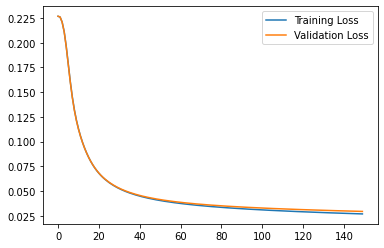

In [150]:
plt.plot(trainLoss, label='Training Loss')
plt.plot(validLoss, label='Validation Loss')
plt.legend()
plt.show()

In [212]:
def softmax_forward( X):
    """
    Softmax activation function
    X: input
    return: output after applying the softmax function
    """
    exp = np.exp(X - np.max(X))
    return exp/np.sum(exp, axis=1, keepdims=True)

# softmax implemetatation incomplete
def softmax_backward( X):
    """
    Softmax activation function
    X: input
    return: output after applying the gradient of softmax function
    """
    # softmax = self.softmax_forward(X)
    # e = np.ones((softmax.shape[0], 1))
    # v1 = np.dot(softmax, e.T)
    # i = np.eye(softmax.shape[0])
    # v2 = i - np.dot(e, softmax.T)
    # return np.multiply(v1, v2)
    X = np.array(X)
    s = X.reshape(-1, 1)
    return np.diagflat(s) - np.dot(s, s.T)


In [213]:
y = [[10, 20]]

In [214]:
softmax_forward(y)

array([[4.53978687e-05, 9.99954602e-01]])

In [215]:
softmax_backward(y)

array([[ -90, -200],
       [-200, -380]])